## Import necessary libraries

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import requests

#load the json data
with open('geo_data.json') as f:
    data = json.load(f)
df= pd.read_csv('food_coded.csv')

## Clean Data and Visualize

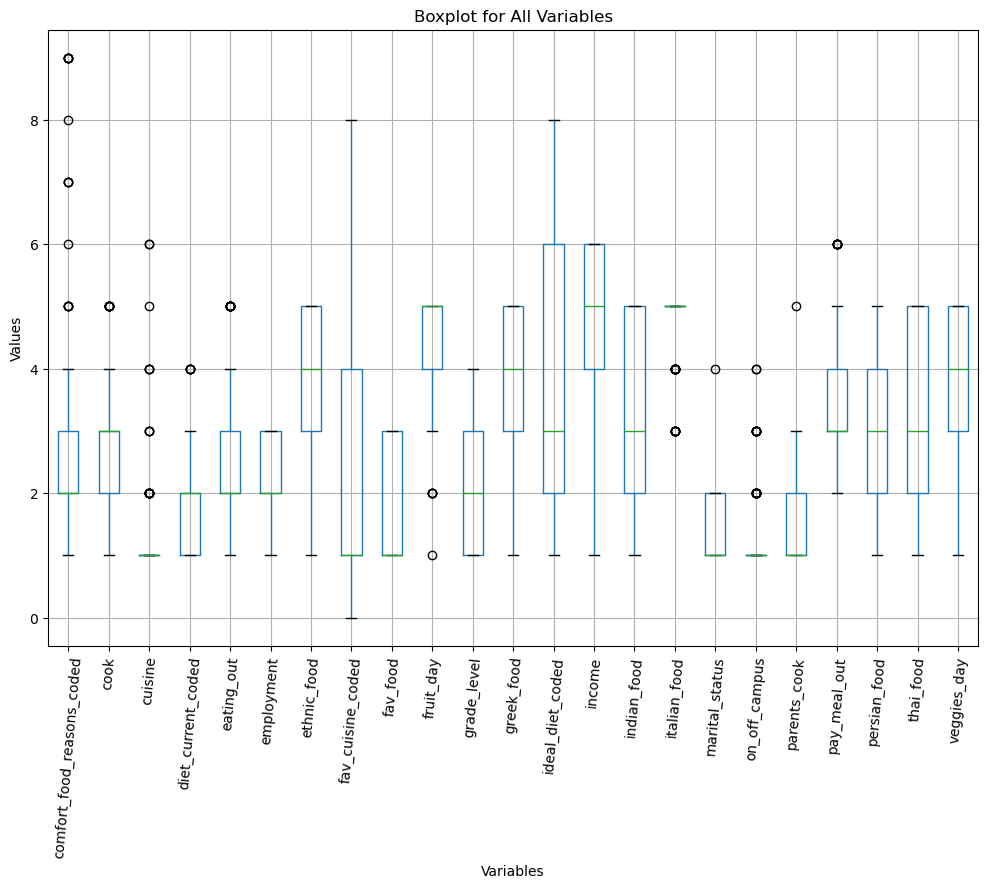

In [18]:
#extract the relevant columns
cols=['comfort_food_reasons_coded','cook','cuisine','diet_current_coded','eating_out','employment','ethnic_food','fav_cuisine_coded','fav_food','fruit_day','grade_level','greek_food','ideal_diet_coded','income','indian_food','italian_food','marital_status','on_off_campus','parents_cook','pay_meal_out','persian_food','thai_food','veggies_day']
df=df[cols]
#drop the null values
df.dropna()
plt.figure(figsize=(12, 8))
df.boxplot(column=cols, rot=85)
plt.title('Boxplot for All Variables')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

## Create New DataFrame from relevant columns

In [6]:
#make the relevant data from json
results = data['results']
extracted_data = []

for item in results:
    fsq_id = item['fsq_id']
    name = item['name']
    dist = item.get('distance',None)
    lat = item['geocodes']['main']['latitude']
    lon = item['geocodes']['main']['longitude']
    addr  = item['location'].get('address',None)
    postcode = item['location'].get('postcode',None)
    region = item['location'].get('region',None)
    
    if item['categories']:
        category = item['categories'][0]['name']
    else:
        category = None
    
    extracted_data.append({
        'fsq_id': fsq_id,
        'name': name,
        'distance': dist,
        'latitude': lat,
        'longitude': lon,
        'address': addr,
        'postcode': postcode,
        'region': region,
        'category': category
    })

geo_df = pd.DataFrame(extracted_data)


### Save the data in a csv file(optional)

In [20]:
csv_file_path = 'data.csv'
geo_df.to_csv(csv_file_path, index=False)
print(f"CSV file saved at {csv_file_path}")
geo_df

CSV file saved at data.csv


,fsq_id,name,distance,latitude,longitude,address,postcode,region,category
0,4b929790f964a5209a0734e3,Nelson A. Rockefeller Park,1029,40.717760,-74.015939,River Ter,10282,NY,Park
1,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,1087,40.706234,-73.996990,None,10038,NY,Monument
2,5e46e2ec5791a10008c55728,Thai Diner,1241,40.720687,-73.995626,186 Mott St,10012,NY,Thai Restaurant
3,430d0a00f964a5203e271fe3,Brooklyn Bridge Park,1415,40.702953,-73.993270,East River waterfront,11201,NY,Park
4,4fd4ff3ce4b0bd432923a7c7,Brooklyn Bridge Park Pebble Beach,1622,40.704331,-73.990182,None,11201,NY,Beach
5,49f37c28f964a520a36a1fe3,Astor Wine & Spirits,2010,40.727937,-73.992812,399 Lafayette St,10003,NY,Wine Store
6,3fd66200f964a5203ee71ee3,Murray’s Cheese,2042,40.731003,-74.003062,254 Bleecker St,10014,NY,Cheese Store
7,50e35a0ae4b0437c4ed45ae7,Pier 5 Soccer Fields,2072,40.694438,-74.001049,None,10004,NY,Soccer Field
8,40abf500f964a52035f31ee3,Washington Square Park,2129,40.730823,-73.997332,5 Avenue A,10009,NY,Urban Park
9,51831ab0498e2d9631ad4c05,Book Club Bar,2218,40.723019,-73.983190,197 E 3rd St,10009,NY,Bookstore


## Extract the coordinates of the location

In [9]:
# Load the initial JSON data
with open('geo_data.json') as f:
    data = json.load(f)

# Extract residential locations
residential_locations = []
for item in data['results']:
    if item['categories']:
        for category in item['categories']:
            if category['name'].lower() == 'residential':
                residential_locations.append({
                    'latitude': item['geocodes']['main']['latitude'],
                    'longitude': item['geocodes']['main']['longitude']
                })


## Get Neighbouring Locations

In [21]:

# Load the initial JSON data
with open('geo_data.json') as f:
    data = json.load(f)

# Extract residential locations
residential_locations = [
    {
        'latitude': item['geocodes']['main']['latitude'],
        'longitude': item['geocodes']['main']['longitude']
    }
    for item in data['results']
]

# Define Foursquare API credentials
FOURSQUARE_API_KEY = 'your api key'
HEADERS = {
    "accept": "application/json",
    "Authorization": FOURSQUARE_API_KEY
}



## Specify the different categories

In [22]:
categories = {
    'grocery_store': '4bf58dd8d48988d118951735',
    'restaurant': '4d4b7105d754a06374d81259',
    'gym': '4bf58dd8d48988d175941735',
    'pharmacy': '4bf58dd8d48988d10f951735',
    'park': '4bf58dd8d48988d163941735',
    'vegetarian_restaurant': '4bf58dd8d48988d1d3941735',
    'vegetable_store': '4bf58dd8d48988d1fa941735'
}



## Prepare dataframe for neighbouring locations

In [13]:

# Function to query nearby places
def query_nearby_places(lat, lon, category_id,radius=1000):
    url = "https://api.foursquare.com/v3/places/search"
    params = {
        'll': f'{lat},{lon}',
        'categories': category_id,
        'radius': radius, 
        'limit': 50
    }
    response = requests.get(url, headers=HEADERS, params=params)
    if response.status_code == 200:
        return response.json().get('results', [])
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return []

# Query nearby places for each residential location
nearby_places_counts = []
for location in residential_locations:
    counts = {
        'latitude': location['latitude'],
        'longitude': location['longitude'],
        'grocery_store': 0,
        'restaurant': 0,
        'gym': 0,
        'park': 0,
        'vegetarian_restaurant': 0,
        'vegetarian_store': 0 
        
    }
    for category, category_id in categories.items():
        places = query_nearby_places(location['latitude'], location['longitude'], category_id)
        counts[category] = len(places)
    nearby_places_counts.append(counts)

# Create DataFrame
nearby_places_df = pd.DataFrame(nearby_places_counts)

# Save DataFrame to CSV
csv_file_path = 'nearby_places_counts.csv'
nearby_places_df.to_csv(csv_file_path, index=False)

print(f"CSV file saved at {csv_file_path}")



CSV file saved at nearby_places_counts.csv


In [15]:
nearby_places_df


,latitude,longitude,grocery_store,restaurant,gym,park,vegetarian_restaurant,vegetarian_store,pharmacy,vegetable_store
0,40.717760,-74.015939,15,39,43,50,6,0,0,6
1,40.706234,-73.996990,10,32,29,50,10,0,0,2
2,40.720687,-73.995626,26,34,50,50,29,0,0,12
3,40.702953,-73.993270,17,35,38,50,4,0,0,1
4,40.704331,-73.990182,10,19,35,50,3,0,0,2
5,40.727937,-73.992812,22,32,50,50,37,0,0,19
6,40.731003,-74.003062,22,39,43,50,21,0,0,4
7,40.694438,-74.001049,20,29,31,50,2,0,0,2
8,40.730823,-73.997332,19,33,42,50,28,0,0,24
9,40.723019,-73.983190,25,30,50,50,33,0,0,3


## Run Kmeans clustering and Visualize using Folium

In [16]:
import folium
from sklearn.cluster import KMeans

# Assuming df is your DataFrame containing latitude and longitude columns
X = nearby_places_df[['latitude', 'longitude']]

# 1. Run K Means Clustering
# Assuming k is the optimal K value
k=4
kmeans = KMeans(n_clusters=k)
cluster_labels = kmeans.fit_predict(X)

# 2. Visualize Results with Folium
# Centered on a chosen location (e.g., latitude and longitude)
map_center = [nearby_places_df['latitude'].mean(), nearby_places_df['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=10)

# Define a color scheme for clusters
colors = ['red', 'blue', 'green', 'yellow', 'purple']  # Add more colors if needed

# Add markers for each data point
for index, row in nearby_places_df.iterrows():

    label = folium.Popup(f"Cluster: {cluster_labels[index]}", parse_html=True)
    folium.CircleMarker(
        [row['latitude'], row['longitude']],
        radius=5,
        popup=label,
        color=colors[cluster_labels[index]],
        fill=True,
        fill_color=colors[cluster_labels[index]],
        fill_opacity=0.7,
        parse_html=False
    ).add_to(mymap)

# 3. Display the map
mymap.save("cluster_map.html")
mymap


## See the details of each cluster

In [17]:

# Add cluster labels to nearby_places_df
nearby_places_df['cluster_label'] = cluster_labels

# Create an empty DataFrame to store counts for all clusters
all_cluster_df = pd.DataFrame()
for i in range(0, k):
    cluster_data = nearby_places_df[nearby_places_df['cluster_label'] == i]
    # Calculate the counts of different categories within that cluster
    restaurant_count = cluster_data['restaurant'].sum()
    grocery_store_count = cluster_data['grocery_store'].sum()
    gym_count = cluster_data['gym'].sum()
    park_count = cluster_data['park'].sum()
    vegetarian_restaurant_count = cluster_data['vegetarian_restaurant'].sum()
    vegetarian_store_count = cluster_data['vegetarian_store'].sum()
    new_df = pd.DataFrame({
        #'cluster_color': [color],
        'cluster_label': [i],
        'restaurant_count': [restaurant_count],
        'grocery_store_count': [grocery_store_count],
        'gym_count': [gym_count],
        'park_count': [park_count],
        'vegetarian_restaurant_count': [vegetarian_restaurant_count],
        'vegetarian_store_count': [vegetarian_store_count]
    })
# Concatenate new_df with all_cluster_df
    all_cluster_df = pd.concat([all_cluster_df, new_df], ignore_index=True)


# Print the DataFrame with counts for all clusters
all_cluster_df

,cluster_label,restaurant_count,grocery_store_count,gym_count,park_count,vegetarian_restaurant_count,vegetarian_store_count
0,0,115,57,133,200,19,0
1,1,138,89,185,200,115,0
2,2,39,15,43,50,6,0
3,3,30,25,50,50,33,0
